In [2]:
from __future__ import print_function

import csv
import codecs
import sys
import string
import time
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from random import shuffle 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.classify import SklearnClassifier
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA, FastICA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

def parseReview(line):
    if line[1] == "__label1__":
        s = 0
    else:
        s = 1
    return (line[0], line[2], line[3], line[4], line[8], s)

def preProcess(text):
    m = {key: "" for key in string.punctuation}
    #table = string.maketrans(m)
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    #stop_words.add("br")
    text = text.translate(m)
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
        filtered_tokens = [' '.join(l) for l in nltk.bigrams(lemmatized_tokens)] + lemmatized_tokens
    return filtered_tokens

def loadData(path):
    rawData = []
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)
        categories = {}
        ind = 0
        for line in reader:
            (Id, rating, verified_purchase, product_category, text, Label) = parseReview(line)
            if product_category not in categories:
                category = ind
                categories[product_category] = ind
                ind += 1
            vp = 1 if verified_purchase == 'Y' else 0
            filtered_tokens = preProcess(unicode(text, 'utf-8'))
            # Only use text field
            #rawData.append([' '.join(filtered_tokens), Label])
            # Use all fields
            rawData.append([' '.join(filtered_tokens), len(filtered_tokens), vp, int(rating), Label])
    shuffle(rawData)
    Y = [x[-1] for x in rawData]
    support = [[x[1], x[2], x[3]] for x in rawData]
    X = [x[0] for x in rawData]
    return X, Y, support


def processData(rawData):
    X = []
    stop_words = set(stopwords.words('english'))
    #stop_words.add("br")
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(rawData)
    V = vectorizer.vocabulary_
    X = X.toarray()
    D = {v:k for k, v in V.iteritems()}
    return X, D
        
def crossValidate(trainData, folds, classifier):
    cv_results = []
    foldsize = int (len(trainData)//folds)
    for i in xrange(0, len(trainData), foldsize):
        pipeline = Pipeline([('', classifier)])
        clf = SklearnClassifier(pipeline).train(trainData[:i] + trainData[foldsize + i:])
        y_pred = clf.classify_many(map(lambda t : t[0], trainData[i:foldsize + i]))
        a, p, r, f = predict(trainData[i:foldsize + i], y_pred)
        cv_results.append((a, p, r, f))
    cv_results = (np.mean(np.array(cv_results), axis=0))
    return cv_results, clf

def plot_boosting_deviance(clf, params, X_test, y_test):
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
	test_score[i] = clf.loss_(y_test, y_pred)
	plt.figure()
	plt.title('Deviance')
	plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
		 label='Training Set Deviance')
	plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
		 label='Test Set Deviance')
	plt.legend(loc='upper right')
	plt.xlabel('Boosting Iterations')
	plt.ylabel('Deviance')
        fig = plt.gcf()
        fig.savefig('boosting deviance')

[nltk_data] Downloading package punkt to /home/junyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/junyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/junyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
rawData, Y, support = loadData('reviews_4000.txt')
X, V= processData(rawData)
Y = np.array(Y)
print(V)

{0: u'00', 1: u'000', 2: u'01', 3: u'02', 4: u'02r5rsx85p8e3fya47jd', 5: u'03', 6: u'055338516x', 7: u'07', 8: u'0tspa9fmspbz02bgy1b1', 9: u'10', 10: u'100', 11: u'1000', 12: u'1000w', 13: u'100km', 14: u'101', 15: u'105', 16: u'107', 17: u'1080p', 18: u'10lbs', 19: u'10mph', 20: u'10x', 21: u'10yr', 22: u'11', 23: u'110', 24: u'1100', 25: u'110v', 26: u'112', 27: u'11ac', 28: u'11g', 29: u'11lbs', 30: u'11n', 31: u'11th', 32: u'12', 33: u'120', 34: u'120mm', 35: u'1225', 36: u'125', 37: u'128gb', 38: u'129', 39: u'12naryx', 40: u'12w', 41: u'12years', 42: u'12\xbc', 43: u'13', 44: u'130', 45: u'130lbs', 46: u'135', 47: u'1365394177', 48: u'136lbs', 49: u'138', 50: u'139', 51: u'13fe6i1', 52: u'13njs94', 53: u'13th', 54: u'13xdw5q', 55: u'13zgr7a', 56: u'13\xbd', 57: u'14', 58: u'1428504525', 59: u'14\xbe', 60: u'15', 61: u'150', 62: u'1500', 63: u'150lbs', 64: u'1568332610', 65: u'15919', 66: u'1599', 67: u'15lb', 68: u'15mb', 69: u'15th', 70: u'15ts', 71: u'15\xbe', 72: u'16', 73: u'

In [55]:
starttime = time.time()
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
reduced_data = preprocessing.scale(reduced_data)
print("PCA time is ", time.time()-starttime)

PCA time is  2.83410692215


In [58]:
print(pca.components_[0])
a0 = pca.components_[1]
print(a0.shape[0])
for i in xrange(a0.shape[0]):
    if a0[i] >= 0.05:
        print(V[i], a0[i])
x = np.argmax(pca.components_[0])

[-3.40325477e-06  3.12844016e-04 -2.43411317e-04 ... -3.81295812e-04
 -3.09633695e-04 -3.09633695e-04]
12839
bad 0.058809230381161724
battery 0.05260836248280726
easy 0.09017358790735369
good 0.2882859134909489
great 0.06192805073632399
money 0.06737082158347782
phone 0.0909622086536617
price 0.15589717185734644
product 0.5480510430727407
quality 0.2282569396984978
recommend 0.051896766179244345
sound 0.08596648510388691
tv 0.05695996387336477
use 0.1434858119627819
work 0.13103249211541423


In [166]:
print(reduced_data.shape)

(1500, 4)


In [12]:
newdata = []
for i in xrange(reduced_data.shape[0]):
    newdata.append(np.append(reduced_data[i], support[i]))
newdata = np.array(newdata)
newdata = preprocessing.scale(newdata)
print(newdata.shape)
print(newdata[:10])

(3997, 5)
[[-0.64879434 -2.55827271 -0.57691273  0.94236358  1.07649945]
 [-0.34502365 -0.61455391  0.32468073  0.94236358  1.07649945]
 [-0.2796003  -0.08117727 -0.48200816 -1.06116155  1.07649945]
 [-0.3164493  -0.06473127 -0.31592515 -1.06116155 -1.20291162]
 [-0.30559019  0.08125893 -0.5057343   0.94236358 -1.96271531]
 [-0.46767727  0.64197863 -0.29219901  0.94236358  1.07649945]
 [-0.35885832 -0.4334918  -0.3396513  -1.06116155  0.31669576]
 [-0.38596804 -0.19180195 -0.41082973 -1.06116155  0.31669576]
 [-0.28260973  1.96797959 -0.22102058  0.94236358  0.31669576]
 [ 3.56927271  0.12813827  0.68057289  0.94236358  0.31669576]]


In [11]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

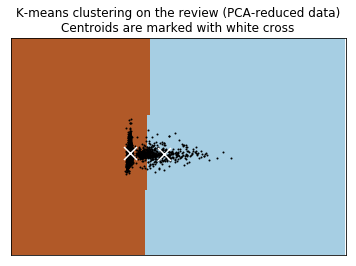

In [12]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the review (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
fig = plt.gcf()
fig.savefig('PCA2_all_field')

In [163]:
predict = kmeans.labels_.astype(np.int)
precision, recall, _, _ = precision_recall_fscore_support(Y, predict, average = 'micro')
print(precision, recall)

ValueError: Found input variables with inconsistent numbers of samples: [3997, 1500]

Evaluate of GaussianMixture with random init
running time is 48.3361361027 s


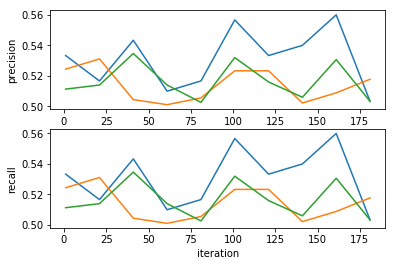

In [10]:
clusters = [
               (GaussianMixture, 'random', {'covariance_type':'diag'}),             
           ]
sample_size = [300, 900, 1500]
max_iters = xrange(1, 200, 20)
clf_error = {}
plt.figure()
ax2 = plt.subplot(211)
ax3 = plt.subplot(212)
legends = []
starttime = time.time()
for factory, init, params in clusters:
    print('Evaluate of {} with {} init'.format(factory.__name__, init))
    for size in sample_size:
        precisions = np.empty(len(max_iters))
        recalls = np.empty(len(max_iters))
        inertia = np.empty(len(max_iters))
        for i, max_iter in enumerate(max_iters):
            #change fit(newdata[:size]) to use PCA
            #change to fit(X[:size]) to use kmeans without reduction
            km = factory(n_components=2, init_params = init, max_iter=max_iter, n_init=2, **params).fit(X[:size])
            predict = km.predict(X[:size])
            precision, recall, _, _ = precision_recall_fscore_support(Y[:size], predict, average = 'micro')
            
            precisions[i] = max(precision, 1 - precision)
            recalls[i] = max(recall, 1 - recall)
        ax2.plot(max_iters, precisions)
        ax3.plot(max_iters, recalls)
        legends.append("{} with size = {}".format(factory.__name__, size))
    fig = plt.gcf()
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('precision')
    ax3.set_xlabel('iteration')
    ax3.set_ylabel('recall')
    fig.savefig('EM_text_only')
print('running time is {} s'.format(time.time()-starttime))